In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as scs
from importlib import reload
import pyspark as ps
from pyspark.ml.classification import RandomForestClassifier

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
ratings = pd.read_csv('data/training.csv')

In [4]:
ratings.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [5]:
ratings.describe()

,user,movie,rating,timestamp
count,800000.000000,800000.000000,800000.000000,8.000000e+05
mean,3403.097837,1849.257256,3.590479,9.683921e+08
std,1546.589028,1086.852485,1.120376,5.820931e+06
min,636.000000,1.000000,1.000000,9.567039e+08
25%,2035.000000,1028.000000,3.000000,9.641524e+08
50%,3507.000000,1788.000000,4.000000,9.675878e+08
75%,4695.000000,2750.000000,4.000000,9.746878e+08
max,6040.000000,3952.000000,5.000000,9.757673e+08


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 4 columns):
user         800000 non-null int64
movie        800000 non-null int64
rating       800000 non-null int64
timestamp    800000 non-null int64
dtypes: int64(4)
memory usage: 24.4 MB


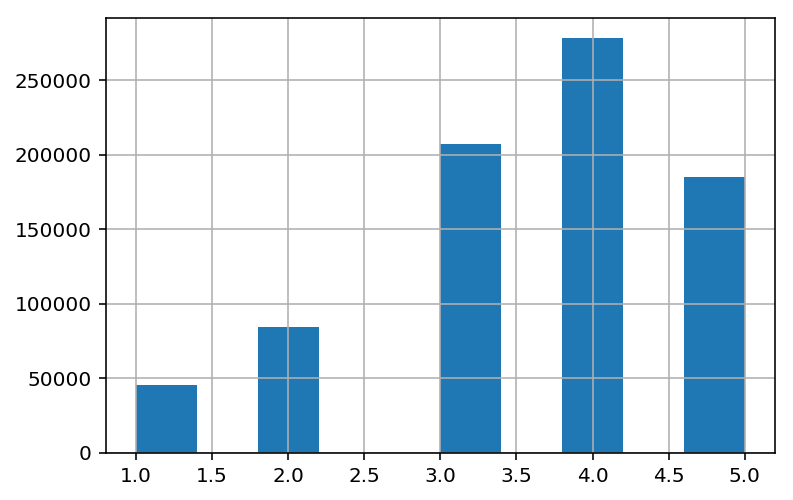

In [7]:
ratings['rating'].hist()

In [8]:
rat_hist = ratings.groupby('rating').count()['user']

In [9]:
rat_hist[0:3].sum(), rat_hist[3:5].sum()

(337093, 462907)

In [10]:
#Splitting on 4/5 vs 1/2/3 MAY NOT BE THE BEST MODEL

ratings['thumbs'] = (ratings['rating'] > 3).astype(int)

In [11]:
ratings['thumbs'].value_counts()

1    462907
0    337093
Name: thumbs, dtype: int64

# DO SUPER AMAZING ALS SPARK SHENANIGINS

In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS

In [13]:
spark = SparkSession.builder.getOrCreate()
spark_df = spark.createDataFrame(ratings) 

In [14]:
spark_df.show(5)

+----+-----+------+---------+------+
|user|movie|rating|timestamp|thumbs|
+----+-----+------+---------+------+
|6040|  858|     4|956703932|     1|
|6040|  593|     5|956703954|     1|
|6040| 2384|     4|956703954|     1|
|6040| 1961|     4|956703977|     1|
|6040| 2019|     5|956703977|     1|
+----+-----+------+---------+------+
only showing top 5 rows



In [15]:
ratings_df = spark_df.drop('timestamp')

In [16]:
train, test = ratings_df.randomSplit([0.8, 0.2], seed=427471138)

In [17]:
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10)


# Train the ALS model. We'll call the trained model `recommender`.
recommender = als_model.fit(train)

In [18]:
#Once again, using thumbs up thumbs down

als_model_thumbs = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='thumbs',
    nonnegative=True,    
    regParam=0.1,
    rank=10)


# Train the ALS model. We'll call the trained model `recommender`.
recommender_thumbs = als_model_thumbs.fit(train)

In [ ]:
# Trying RF

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

recommender = rf.fit(ratings_df)

In [19]:
predict_star = recommender.transform(test)

In [20]:
predict_thumbs = recommender_thumbs.transform(test)

In [51]:
requests = predict_star.toPandas()


In [55]:
requests['prediction'].fillna(requests['prediction'].mean(), inplace=True)

In [56]:
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159972 entries, 0 to 159971
Data columns (total 5 columns):
user          159972 non-null int64
movie         159972 non-null int64
rating        159972 non-null int64
thumbs        159972 non-null int64
prediction    159972 non-null float32
dtypes: float32(1), int64(4)
memory usage: 5.5 MB


In [52]:
predict_star.show(5)

+----+-----+------+------+----------+
|user|movie|rating|thumbs|prediction|
+----+-----+------+------+----------+
|2383|  148|     2|     0| 2.4831443|
|1069|  148|     2|     0| 2.3511102|
|2456|  148|     2|     0| 2.5861793|
|3683|  463|     1|     0| 1.4559566|
|3562|  463|     2|     0|  2.783249|
+----+-----+------+------+----------+
only showing top 5 rows



In [53]:
predict_thumbs.show(5)

+----+-----+------+------+----------+
|user|movie|rating|thumbs|prediction|
+----+-----+------+------+----------+
|2383|  148|     2|     0| 0.2654666|
|1069|  148|     2|     0|0.25691834|
|2456|  148|     2|     0|0.21925913|
|3683|  463|     1|     0|0.13578579|
|3562|  463|     2|     0|0.23611109|
+----+-----+------+------+----------+
only showing top 5 rows



In [54]:
predict_star_df = predict_star.toPandas()
predict_thumbs_df = predict_thumbs.toPandas()

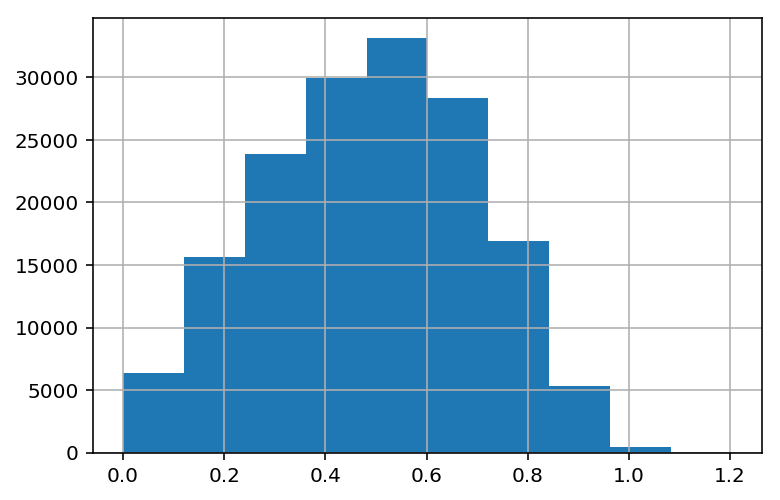

In [55]:
predict_thumbs_df['prediction'].hist()

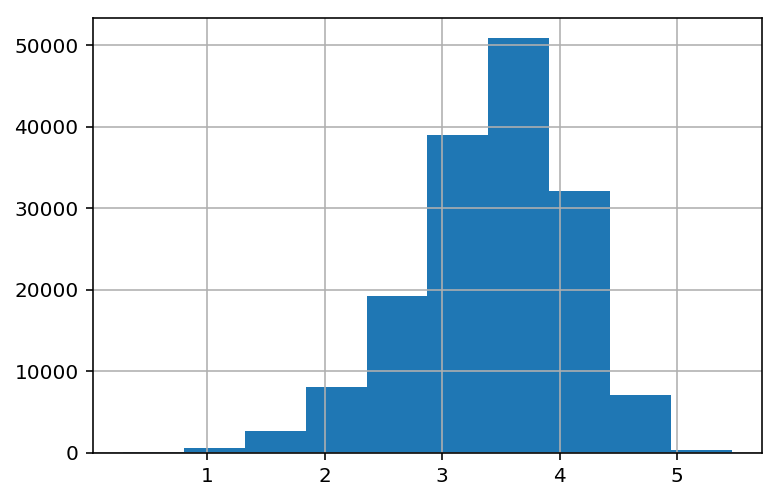

In [57]:
predict_star_df['prediction'].hist()

In [61]:
predict_star_df[predict_star_df['rating'] > 3].sort_values('prediction',ascending = False)

,user,movie,rating,thumbs,prediction
81743,3902,1036,5,1,5.463417
114489,3902,1153,4,1,5.452711
98130,692,50,5,1,5.383601
5869,3596,53,5,1,5.366506
99883,1670,527,5,1,5.359987
27387,3902,1291,5,1,5.342653
14656,1071,2905,5,1,5.342089
132656,5218,260,5,1,5.317472
139007,4801,2762,5,1,5.311224
69272,1732,318,5,1,5.303401


In [62]:
predict_thumbs_df[predict_thumbs_df['thumbs'] == 1].sort_values('prediction',ascending = False)

,user,movie,rating,thumbs,prediction
69204,2155,318,5,1,1.203642
20042,2268,1148,4,1,1.183573
132769,5729,260,5,1,1.122776
11003,2922,1198,5,1,1.118985
76269,2268,2324,5,1,1.106806
5869,3596,53,5,1,1.089957
81743,3902,1036,5,1,1.084906
132738,2922,260,5,1,1.083276
139007,4801,2762,5,1,1.078783
99987,4086,527,5,1,1.077369


In [36]:
test = pd.DataFrame({'a':[1,2,3],'b':[4,5,6]})
test

,a,b
0,1,4
1,2,5
2,3,6


In [42]:
ar = np.array([1,2,3,4,5,6,7])

In [43]:
ar[1]

2

In [45]:
test['c'] = ar[test['a']] + ar[test['b']]

In [46]:
test

,a,b,c
0,1,4,7
1,2,5,9
2,3,6,11
